## Testing solving for product moments using Linear Algebra and Optimization Packages

#### Import Required Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import gaussian_kde,ecdf,t
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import time
from scipy.optimize import minimize

#### Euler Angles Solver Function 

#### Solver Function

In [2]:
def solveForTensor(I_initial, I_x, I_y, I_z, thetad):
    # Define known values
    theta = np.deg2rad(thetad)
    I_xx = I_initial[0]
    I_yy = I_initial[1] 
    I_zz = I_initial[2] 
    I_xx_x = I_x[0] 
    I_yy_x = I_x[1] 
    I_zz_x = I_x[2] 
    I_xx_y = I_y[0] 
    I_yy_y = I_y[1] 
    I_zz_y = I_y[2] 
    I_xx_z = I_z[0]
    I_yy_z = I_z[1]
    I_zz_z = I_z[2] 

    # Construct rotation matrix
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(theta), np.sin(theta)],
                    [0, -np.sin(theta), np.cos(theta)]])
    R_y = np.array([[np.cos(theta), 0, -np.sin(theta)],
                    [0, 1, 0],
                    [np.sin(theta), 0, np.cos(theta)]])
    R_z = np.array([[np.cos(theta), np.sin(theta), 0],
                    [-np.sin(theta),np.cos(theta),0],
                    [0,0,1]])

    # Define a function to minimize
    def objective(x):
        # initial guess
        I_xy, I_xz, I_yz = x

        # Initial tensor with guessed product moments
        I = np.array([[I_xx, I_xy, I_xz],
                    [I_xy, I_yy, I_yz],
                    [I_xz, I_yz, I_zz]])

        # Results after x,y,z rotations
        result_x = np.matmul(R_x, np.matmul(I, np.transpose(R_x)))
        # print('\nRotated Principals x')
        # print((result_x))
        result_y = np.matmul(R_y, np.matmul(I, np.transpose(R_y)))
        # print('\nRotated Principals y')
        # print((result_x))
        result_z = np.matmul(R_z, np.matmul(I, np.transpose(R_z)))
        # print('\nRotated Principals z')

        # Errors on Moments 
        error_x = np.sum(np.power(np.subtract(np.diag(result_x),np.matrix([I_xx_x,I_yy_x,I_zz_x])),2))
        error_y = np.sum(np.power(np.subtract(np.diag(result_y),np.matrix([I_xx_y,I_yy_y,I_zz_y])),2))
        error_z = np.sum(np.power(np.subtract(np.diag(result_z),np.matrix([I_xx_z,I_yy_z,I_zz_z])),2))

        error_net = error_x + error_y + error_z
        # print(error_net)
        # print('\n\n')
        return error_net

    # Initial guess for unknowns
    x0 = [0,0,0]  # Example initial guess, replace with your estimate

    # Minimize the objective function
    res = minimize(objective, x0)

    # Extract the optimized values
    I_xy_opt, I_xz_opt, I_yz_opt = res.x

    I_sovled = np.matrix([[I_xx,I_xy_opt,I_xz_opt],[I_xy_opt,I_yy,I_yz_opt],[I_xz_opt,I_yz_opt,I_zz]])

    return I_sovled

#### Generate fake tensor with small initial angles of rotation

In [3]:
# Small initial angles
theta1 = np.deg2rad(10)
theta2 = np.deg2rad(2.5)
theta3 = np.deg2rad(7)
bigTheta = np.deg2rad(10)

# Rotation Matrices
R_x = np.array([[1, 0, 0],
                    [0, np.cos(theta1), np.sin(theta1)],
                    [0, -np.sin(theta1), np.cos(theta1)]])
R_y = np.array([[np.cos(theta2), 0, -np.sin(theta2)],
                [0, 1, 0],
                [np.sin(theta2), 0, np.cos(theta2)]])
R_z = np.array([[np.cos(theta3), np.sin(theta3), 0],
                [-np.sin(theta3),np.cos(theta3),0],
                [0,0,1]])

# Applying Rotations
# This part 
I_principle=np.array([[0.8,0,0],[0,.2,0],[0,0,.87]])

I_tensor = np.matmul(R_x, np.matmul(I_principle,np.transpose(R_x)))
# print(I_tensor)
I_tensor = np.matmul(R_y, np.matmul(I_tensor,np.transpose(R_y)))
# print(I_tensor)
I_tensor = np.matmul(R_z, np.matmul(I_tensor,np.transpose(R_z)))

# Roration by 30 matrices
R_x_big = np.array([[1, 0, 0],
                     [0, np.cos(bigTheta), np.sin(bigTheta)],
                     [0, -np.sin(bigTheta), np.cos(bigTheta)]])
R_y_big = np.array([[np.cos(bigTheta), 0, -np.sin(bigTheta)],
                [0, 1, 0],
                [np.sin(bigTheta), 0, np.cos(bigTheta)]])
R_z_big = np.array([[np.cos(bigTheta), np.sin(bigTheta), 0],
                [-np.sin(bigTheta),np.cos(bigTheta),0],
                [0,0,1]])

# Getting Rotated Values
I_tensor_x = np.matmul(R_x_big, np.matmul(I_tensor,np.transpose(R_x_big)))
# print(I_tensor_x)
I_tensor_y = np.matmul(R_y_big, np.matmul(I_tensor,np.transpose(R_y_big)))
# print(I_tensor_y)
I_tensor_z = np.matmul(R_z_big, np.matmul(I_tensor,np.transpose(R_z_big)))


[[ 0.79027304 -0.07499357  0.01179623]
 [-0.07499357  0.23002467  0.11387893]
 [ 0.01179623  0.11387893  0.84970228]]


#### Set up statistical model of data input

#### Set up simulation 

In [4]:
numTrials = 200
variance = 0.002
percent_error = np.zeros((3,3))
error = {}
error['Pre-Tensor Average'] = np.zeros((3,3,numTrials))
error['Post-Tensor Average'] = np.zeros((3,3,numTrials))
# print(error['Pre-Tensor Average'][:][:][1])
print(error['Post-Tensor Average'][:,:,0].shape)

(3, 3)


#### Run Simulation 

In [5]:
for i in range(numTrials):
    # Post-Tensor Average
    for j in range(45):
        meanError = np.random.default_rng().normal(0,sampMeanStdDev,1)
        measurementError = np.random.default_rng().normal(meanError,sampStdDev,(4,3))
        I_solved = solveForTensor(np.diag(I_tensor)+measurementError[0,:],
                                    np.diag(I_tensor_x)+measurementError[1,:],
                                    np.diag(I_tensor_y)+measurementError[2,:],
                                    np.diag(I_tensor_z)+measurementError[3,:],10)
        percent_error = percent_error + np.divide(np.subtract(I_tensor,I_solved),I_solved)*100

    percent_error = percent_error/45
    error['Post-Tensor Average'][:,:,i] = percent_error
    
    # Pre-Tensor Average
    measurementError = np.random.default_rng().normal(0,sampMeanStdDev,(4,3))
    percent_error = np.divide(np.subtract(I_tensor,I_solved),I_solved)*100
    I_solved = solveForTensor(np.diag(I_tensor)+measurementError[0,:],
                                    np.diag(I_tensor_x)+measurementError[1,:],
                                    np.diag(I_tensor_y)+measurementError[2,:],
                                    np.diag(I_tensor_z)+measurementError[3,:],10)
    percent_error = np.divide(np.subtract(I_tensor,I_solved),I_solved)*100
    error['Pre-Tensor Average'][:,:,i] = percent_error
    print(i)


    

0
1
2
3
4
5


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


#### Plot Results (scaled axes)

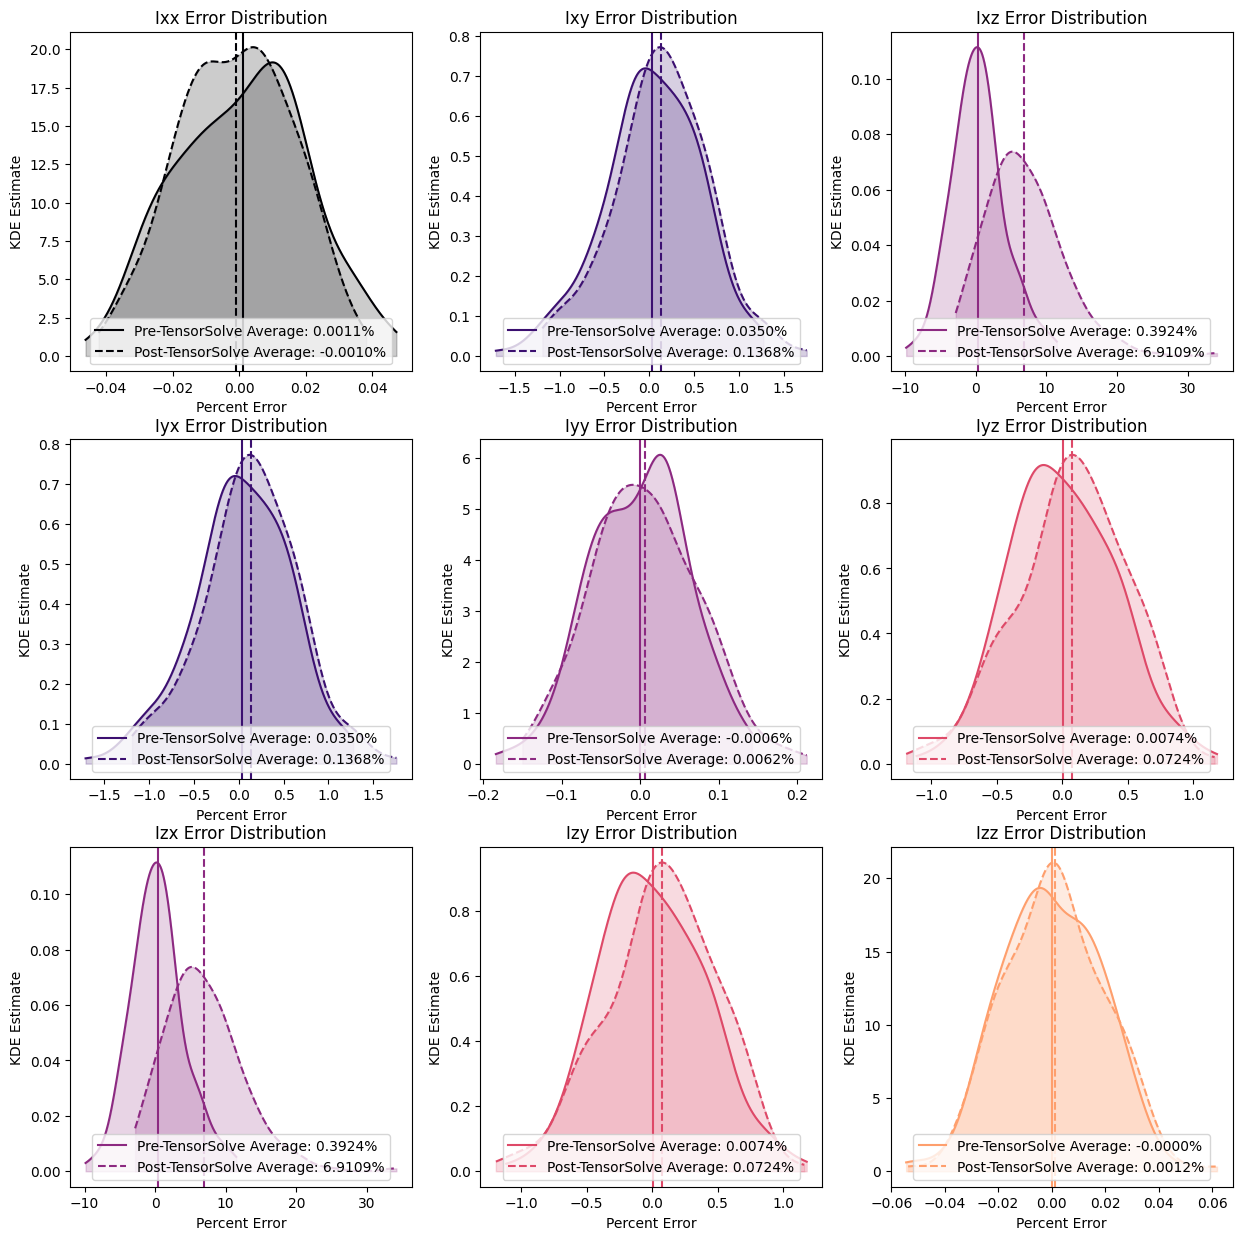

In [6]:
fig, axs = plt.subplots(3,3,figsize=(15,15))
# Define the number of iterations
num_iterations = 9

# Create evenly spaced indices for selecting colors
color_indices = np.linspace(0, 0.8, num_iterations)

# Create a colormap object
cmap = plt.get_cmap('magma')

# Define a list to store colors
colors = []

# Select colors from the 'magma' colormap with varying intensities
for index in color_indices:
    colors.append(cmap(index))

# Assuming axs is already defined somewhere in your code
for i in range(3):
    for j in range(3):
        # print(error['Pre-Tensor Average'].shape)
        pre_mean = np.mean(error['Pre-Tensor Average'][i,j,:])
        post_mean = np.mean(error['Post-Tensor Average'][i,j,:])
        pre_min = np.min(error['Pre-Tensor Average'][i,j,:])
        post_min = np.min(error['Post-Tensor Average'][i,j,:])
        pre_max = np.max(error['Pre-Tensor Average'][i,j,:])
        post_max = np.max(error['Post-Tensor Average'][i][j][:])
        pre_xi = np.linspace(pre_min,pre_max,1000)
        post_xi = np.linspace(post_min,post_max,1000)
        pre_kde = gaussian_kde(error['Pre-Tensor Average'][i,j,:])
        post_kde = gaussian_kde(error['Post-Tensor Average'][i,j,:])
        color = colors[(i + j)*2]  # Select color from the list
        axs[i][j].plot(pre_xi, pre_kde(pre_xi), linestyle='-', color=color,label='Pre-TensorSolve Average: {:.4f}%'.format(pre_mean))
        axs[i][j].plot(post_xi, post_kde(post_xi), linestyle='--', color=color,label='Post-TensorSolve Average: {:.4f}%'.format(post_mean))
        axs[i][j].fill_between(pre_xi, pre_kde(pre_xi), alpha=0.2, color=color)
        axs[i][j].fill_between(post_xi, post_kde(post_xi), alpha=0.2, color=color)
        axs[i][j].axvline(x=pre_mean, linestyle='-', color=color)
        axs[i][j].axvline(x=post_mean, linestyle='--', color=color)
        sum_error = np.sum(error['Pre-Tensor Average'][i,j,:])
        # print(f"Value for i: {i} and Value for j: {j} result in error of {sum_error}")
        axs[i][j].legend(loc='lower center')

for ax in axs.flat:
    ax.set(xlabel='Percent Error', ylabel='KDE Estimate')

axs[0][0].set_title('Ixx Error Distribution')
axs[0][1].set_title('Ixy Error Distribution')
axs[0][2].set_title('Ixz Error Distribution')
axs[1][0].set_title('Iyx Error Distribution')
axs[1][1].set_title('Iyy Error Distribution')
axs[1][2].set_title('Iyz Error Distribution')
axs[2][0].set_title('Izx Error Distribution')
axs[2][1].set_title('Izy Error Distribution')
axs[2][2].set_title('Izz Error Distribution')
plt.show()



#### Plot Error (absolute axes)

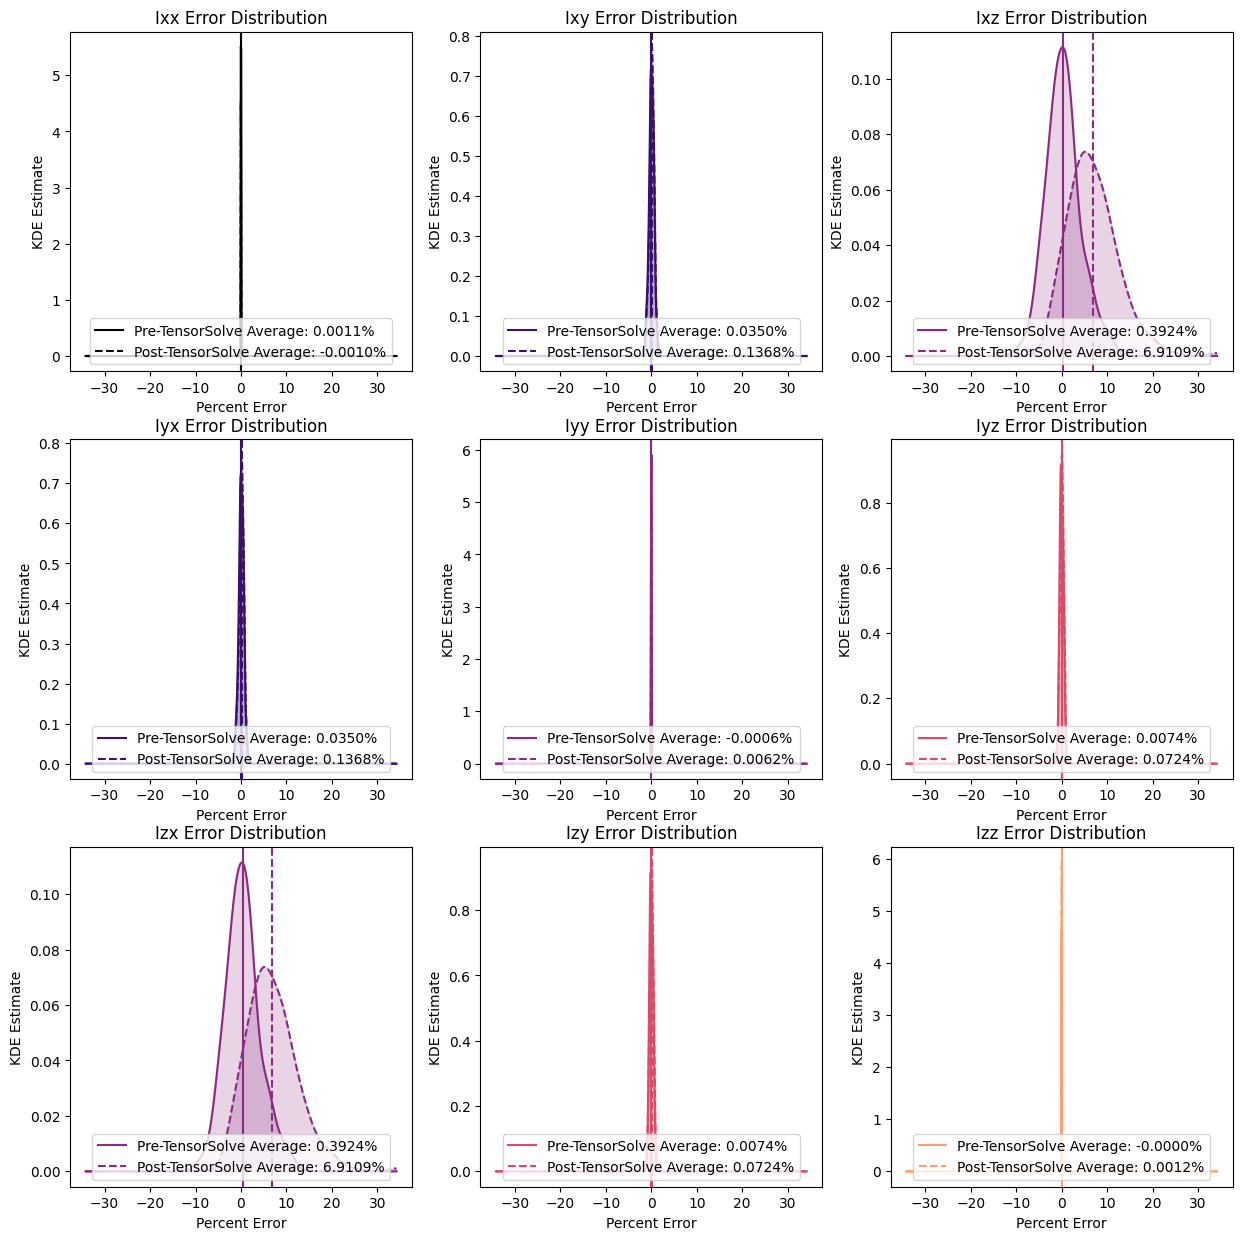

In [7]:
fig, axs = plt.subplots(3,3,figsize=(15,15))
# Define the number of iterations
num_iterations = 9

# Create evenly spaced indices for selecting colors
color_indices = np.linspace(0, 0.8, num_iterations)

# Create a colormap object
cmap = plt.get_cmap('magma')

# Define a list to store colors
colors = []

# Select colors from the 'magma' colormap with varying intensities
for index in color_indices:
    colors.append(cmap(index))

# Assuming axs is already defined somewhere in your code
for i in range(3):
    for j in range(3):
        # print(error['Pre-Tensor Average'].shape)
        pre_mean = np.mean(error['Pre-Tensor Average'][i,j,:])
        post_mean = np.mean(error['Post-Tensor Average'][i,j,:])
        pre_min = np.min(error['Pre-Tensor Average'][i,j,:])
        post_min = np.min(error['Post-Tensor Average'][i,j,:])
        pre_max = np.max(error['Pre-Tensor Average'][i,j,:])
        post_max = np.max(error['Post-Tensor Average'][i][j][:])
        pre_xi = np.linspace(-np.max(error['Post-Tensor Average']),np.max(error['Post-Tensor Average']),1000)
        post_xi = np.linspace(-np.max(error['Post-Tensor Average']),np.max(error['Post-Tensor Average']),1000)
        pre_kde = gaussian_kde(error['Pre-Tensor Average'][i,j,:])
        post_kde = gaussian_kde(error['Post-Tensor Average'][i,j,:])
        color = colors[(i + j)*2]  # Select color from the list
        axs[i][j].plot(pre_xi, pre_kde(pre_xi), linestyle='-', color=color,label='Pre-TensorSolve Average: {:.4f}%'.format(pre_mean))
        axs[i][j].plot(post_xi, post_kde(post_xi), linestyle='--', color=color,label='Post-TensorSolve Average: {:.4f}%'.format(post_mean))
        axs[i][j].fill_between(pre_xi, pre_kde(pre_xi), alpha=0.2, color=color)
        axs[i][j].fill_between(post_xi, post_kde(post_xi), alpha=0.2, color=color)
        axs[i][j].axvline(x=pre_mean, linestyle='-', color=color)
        axs[i][j].axvline(x=post_mean, linestyle='--', color=color)
        sum_error = np.sum(error['Pre-Tensor Average'][i,j,:])
        # print(f"Value for i: {i} and Value for j: {j} result in error of {sum_error}")
        axs[i][j].legend(loc='lower center')

for ax in axs.flat:
    ax.set(xlabel='Percent Error', ylabel='KDE Estimate')

axs[0][0].set_title('Ixx Error Distribution')
axs[0][1].set_title('Ixy Error Distribution')
axs[0][2].set_title('Ixz Error Distribution')
axs[1][0].set_title('Iyx Error Distribution')
axs[1][1].set_title('Iyy Error Distribution')
axs[1][2].set_title('Iyz Error Distribution')
axs[2][0].set_title('Izx Error Distribution')
axs[2][1].set_title('Izy Error Distribution')
axs[2][2].set_title('Izz Error Distribution')
plt.show()


In [8]:
deez = np.zeros((3,3,1000))
print(deez[:][:][1].shape)
print(deez[:,:,1].shape)

(3, 1000)
(3, 3)
